In [1]:
import pandas as pd
import numpy as np
from os import listdir, chdir
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
chdir("./data")


In [2]:
dfs = {}
def get_date(x):
    return datetime.datetime.strptime(str(x.Year)+" "+str(x.variable), "%Y %b")

# Generate dataframes for each food price time series.
for file in listdir():
    if file not in ["slaughter_counts_historical.xlsx", "cpi_allcon_foodbev.csv", "wages_monthly.csv","wages_yearly.csv"]:
        dfs[file[:-5]] = pd.read_excel(file, header = 9).melt(id_vars = ["Year"])
        dfs[file[:-5]]["date"] = dfs[file[:-5]].apply(lambda x: get_date(x), axis =1)#.sort_values(by = ["date"])
        dfs[file[:-5]].sort_values(by = ["date"], inplace = True)

In [4]:
# Generate slaughter counts dataframe
response = pd.read_excel("slaughter_counts_historical.xlsx", header = 2).reset_index()
response.drop([0,1, 915, 916, 917], axis = 0, inplace = True)
response.reset_index(drop = True, inplace = True)
response = response[["index", "Cattle"]]
response.columns = ["date", "cattle"]
response["date"] = response["date"].apply(lambda x: datetime.datetime.strptime(x, "%b-%Y"))
response.sort_values(by = ["date"], inplace = True)

In [6]:
# Load in CPI data
cpi = pd.read_csv("cpi_allcon_foodbev.csv")
cpi["DATE"] = cpi["DATE"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
cpi.columns = ["date","cpi"]

In [16]:
# Get inflation adjusted price values
# Modify cut dataframes to only have date, price value, and inflation adjusted price value.
for cut in dfs.keys():
    dfs[cut] = pd.merge(dfs[cut], cpi)
    dfs[cut]["inf_adj"] = dfs[cut].apply(lambda x: (x.value/x.cpi)*100, axis = 1)
    dfs[cut] = dfs[cut][["date","value","inf_adj"]]

In [22]:
# Generate demand variable for each cut
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

for cut in dfs.keys():
    dfs[cut] = pd.merge(dfs[cut], response, on = ["date"]).dropna()
    linreg.fit(np.stack(dfs[cut]["cattle"].apply(lambda x: [x])), np.array(dfs[cut]["inf_adj"]))
    preds = linreg.predict(np.stack(dfs[cut]["cattle"].apply(lambda x: [x])))
    resids = dfs[cut]["inf_adj"] - preds
    dfs[cut]["demand"] = resids


In [26]:
print(dfs.keys())

dict_keys(['all_uncooked_beef_roasts', 'all_uncooked_beef_steaks', 'all_uncooked_ground_beef', 'all_uncooked_other_beef', 'beef_for_stew', 'chuck_roast_non_usda', 'chuck_roast_usda', 'ground_beef', 'ground_beef_lean', 'ground_chuck', 'round_roast_non_usda', 'round_roast_usda', 'steak_round_non_usda', 'steak_round_usda', 'steak_sirloin_non_usda', 'steak_sirloin_usda'])


In [39]:
from functools import reduce

dfs_for_export = ["all_uncooked_beef_roasts", "all_uncooked_beef_steaks", "all_uncooked_ground_beef", "all_uncooked_other_beef"]

for df in dfs_for_export:
    dfs[df].rename(columns = {"demand" : "demand"+df}, inplace = True)
    
dfs_for_export = [dfs["all_uncooked_beef_roasts"], dfs["all_uncooked_beef_steaks"], dfs["all_uncooked_ground_beef"], dfs["all_uncooked_other_beef"]]


df_for_export = reduce(lambda left, right: pd.merge(left, right, on = ["date"]), dfs_for_export)

In [41]:
df_for_export = df_for_export[["date","demandall_uncooked_beef_roasts","demandall_uncooked_beef_steaks","demandall_uncooked_ground_beef","demandall_uncooked_other_beef","date","cattle_x"]]

In [44]:
df_for_export = df_for_export.loc[:,~df_for_export.columns.duplicated()]


In [47]:
df_for_export.rename(columns = {"cattle_x":"cattle"}, inplace = True)

C:\Users\natha\Anaconda3\lib\site-packages\pandas\core\frame.py:2844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [49]:
df_for_export.to_csv("beefdemand.csv", header = True, index = False)

C:\Users\natha\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\natha\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\natha\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single fea

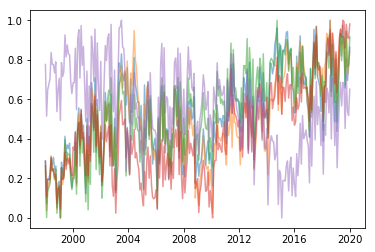

In [54]:
for colname in df_for_export.columns[1:]:
    plt.plot(df_for_export["date"], min_max_scaler.fit_transform(df_for_export[colname]), alpha = 0.5, label = colname)
    